In [1]:
from datetime import datetime
from datetime import timedelta

import pandas
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

Importing plotly failed. Interactive plots will not work.


## Load and Prepare Data

In [2]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release", "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["month"]
del df["day"]
del df["year"]
del df["post_month"]

In [3]:
df.query("release_post == True & days_since_previous_release.isnull()")

,days_since_previous_release,release_post,date
id,,,


In [4]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [5]:
filled_in = [dict(df.iloc[0])]
# df should already be sorted by date
current_date = filled_in[0]["date"]
days_since_release = filled_in[0]["days_since_previous_release"] # should be 0
while current_date < df.iloc[-1]["date"]:
    days_since_release += 1
    current_date = current_date + timedelta(days=1)
    in_df = df[df["date"] == current_date]
    if len(in_df) == 1:
        filled_in.append({"date" : current_date, "release_post" : in_df.iloc[0]["release_post"],
                          "days_since_previous_release" : days_since_release})
        days_since_release = 0
    else:
        filled_in.append({"date" : current_date, "release_post" : False,
                          "days_since_previous_release" : days_since_release})
        
features_df = pandas.DataFrame(filled_in)
features_df.tail()

,days_since_previous_release,release_post,date
1515,5.0,False,2021-04-12
1516,6.0,False,2021-04-13
1517,7.0,False,2021-04-14
1518,8.0,False,2021-04-15
1519,9.0,True,2021-04-16


In [6]:
features_df["release_post"].value_counts()

False    1326
True      194
Name: release_post, dtype: int64

In [7]:
features_df["weekday"] = features_df["date"].apply(lambda x : x.weekday())
features_df["month"] = features_df["date"].apply(lambda x : x.month)
features_df.tail()

,days_since_previous_release,release_post,date,weekday,month
1515,5.0,False,2021-04-12,0,4
1516,6.0,False,2021-04-13,1,4
1517,7.0,False,2021-04-14,2,4
1518,8.0,False,2021-04-15,3,4
1519,9.0,True,2021-04-16,4,4


In [8]:
train_df = features_df[0:int(len(features_df) * 0.8)].copy()
test_df = features_df[~features_df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

1216 304


In [9]:
train_df = train_df.rename(columns={"date" : "ds", "release_post" : "y"})
test_df = test_df.rename(columns={"date" : "ds", "release_post" : "y"})

---

In [10]:
def evaluate(df):
    print("Pearson =", df[["y", "yhat"]].corr().iloc[0][1])
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    precisions = []
    recalls = []
    for threshold in thresholds:
        tp = len(df.query('y == 1 & yhat >= {}'.format(threshold)))
        fp = len(df.query('y != 1 & yhat >= {}'.format(threshold)))
        fn = len(df.query('y == 1 & yhat < {}'.format(threshold)))
        precisions.append(tp / (tp + fp))
        recalls.append(tp / (tp + fn))
        
    f1s = [2 * ((p * r) / (p + r)) for (p, r) in zip(precisions, recalls)]
        
    best_index = f1s.index(max(f1s))
    print("Best F1 =", f1s[best_index])
    print("Precision =", precisions[best_index])
    print("Recall =", recalls[best_index])
    print("Threshold =", thresholds[best_index])
        
    sns.lineplot(x=thresholds, y=f1s).set(xlabel="Threshold", ylabel="F1")

---

## No Additional Features or Information

In [11]:
m1 = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)

In [12]:
m1.fit(train_df[["ds", "y"]])

In [13]:
predictions1 = m1.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions1["yhat"] = scaler.fit_transform(predictions1[["yhat"]])
# predictions1["yhat"].describe()

In [14]:
predictions1 = predictions1.merge(test_df, on=["ds"])

Pearson = 0.026521777658147536
Best F1 = 0.22508038585209003
Precision = 0.1282051282051282
Recall = 0.9210526315789473
Threshold = 0.1


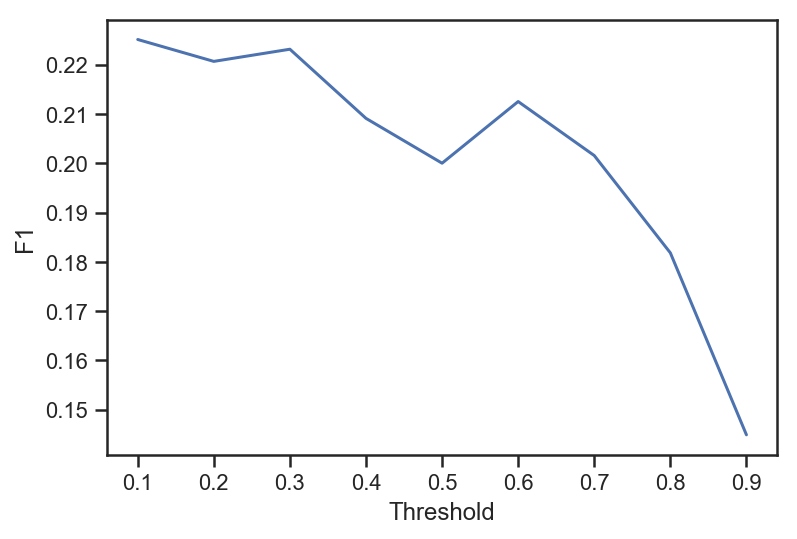

In [15]:
evaluate(predictions1)

In [16]:
# sns.scatterplot(data=predictions1, x="y", y="yhat", hue="y")

In [17]:
# temp = predictions1.copy()
# temp["yhat"] = temp["yhat"].round(2)
# temp = temp.groupby(["y", "yhat"]).size().reset_index()
# sns.scatterplot(data=temp, x="yhat", y=0, hue="y")

---

## Adding Weekly Seasonality

In [18]:
m2 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)

In [19]:
m2.fit(train_df[["ds", "y"]])

In [20]:
predictions2 = m2.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions2["yhat"] = scaler.fit_transform(predictions2[["yhat"]])
# predictions2["yhat"].describe()

In [21]:
predictions2 = predictions2.merge(test_df, on=["ds"])

Pearson = 0.08366015655634751
Best F1 = 0.24413145539906103
Precision = 0.14857142857142858
Recall = 0.6842105263157895
Threshold = 0.5


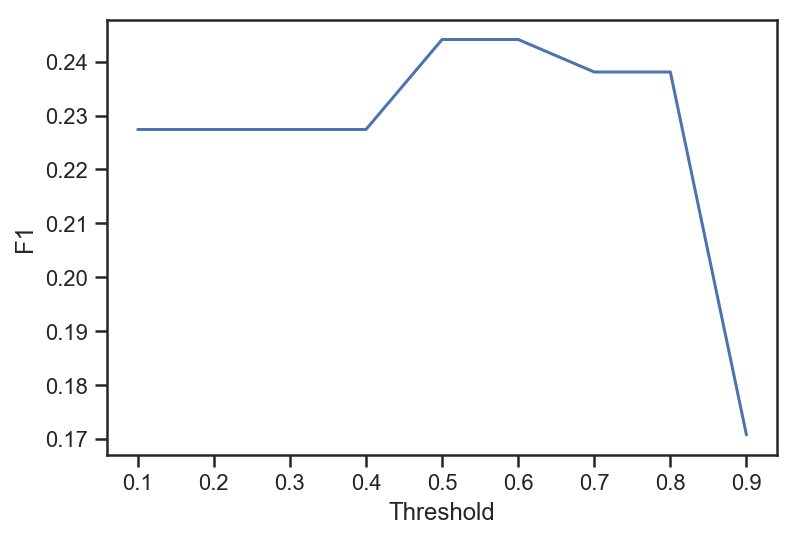

In [22]:
evaluate(predictions2)

---

## Weekly + Daily Seasonality

In [23]:
m3 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)

In [24]:
m3.fit(train_df[["ds", "y"]])

In [25]:
predictions3 = m3.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions3["yhat"] = scaler.fit_transform(predictions3[["yhat"]])
# predictions3["yhat"].describe()

In [26]:
predictions3 = predictions3.merge(test_df, on=["ds"])

Pearson = 0.08363727750419703
Best F1 = 0.24413145539906103
Precision = 0.14857142857142858
Recall = 0.6842105263157895
Threshold = 0.5


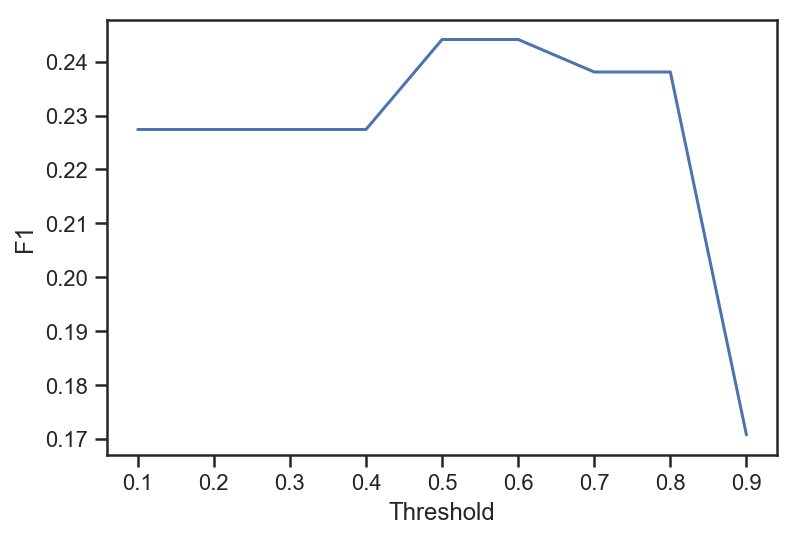

In [27]:
evaluate(predictions3)

---

## Weekly + Yearly Seasonality

In [28]:
m4 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

In [29]:
m4.fit(train_df[["ds", "y"]])

In [30]:
predictions4 = m4.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions4["yhat"] = scaler.fit_transform(predictions4[["yhat"]])
# predictions4["yhat"].describe()

In [31]:
predictions4 = predictions4.merge(test_df, on=["ds"])

Pearson = 0.09459892115689844
Best F1 = 0.2857142857142857
Precision = 0.24528301886792453
Recall = 0.34210526315789475
Threshold = 0.8


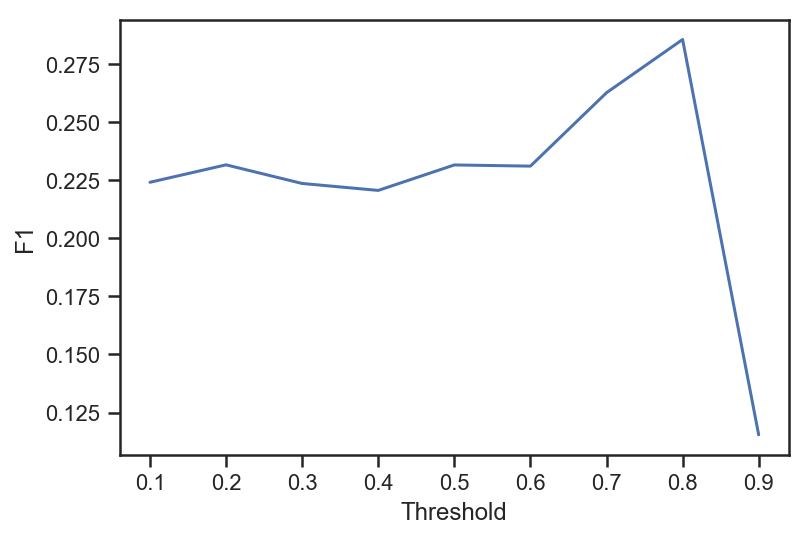

In [32]:
evaluate(predictions4)

---

## Weekly Seasonality + Yearly Seasonality + US Holidays

In [33]:
m5 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m5.add_country_holidays(country_name="US")

In [34]:
m5.fit(train_df[["ds", "y"]])

In [35]:
predictions5 = m5.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions5["yhat"] = scaler.fit_transform(predictions5[["yhat"]])
# predictions5["yhat"].describe()

In [36]:
predictions5 = predictions5.merge(test_df, on=["ds"])

Pearson = 0.08841218313748878
Best F1 = 0.2826086956521739
Precision = 0.24074074074074073
Recall = 0.34210526315789475
Threshold = 0.8


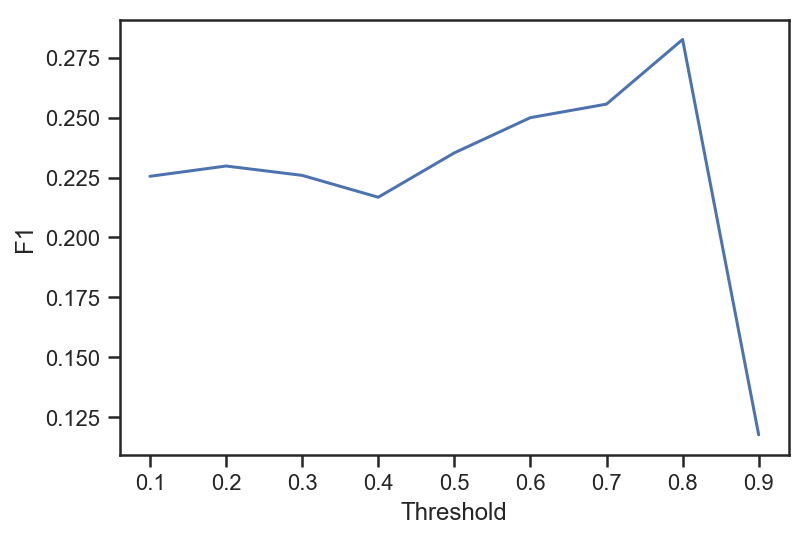

In [37]:
evaluate(predictions5)

---

## Weekly Seasonality + US Holidays

In [38]:
m6 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
m6.add_country_holidays(country_name="US")

In [39]:
m6.fit(train_df[["ds", "y"]])

In [40]:
predictions6 = m6.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions6["yhat"] = scaler.fit_transform(predictions6[["yhat"]])
# predictions6["yhat"].describe()

In [41]:
predictions6 = predictions6.merge(test_df, on=["ds"])

Pearson = 0.07814795975050214
Best F1 = 0.2403846153846154
Precision = 0.14705882352941177
Recall = 0.6578947368421053
Threshold = 0.6


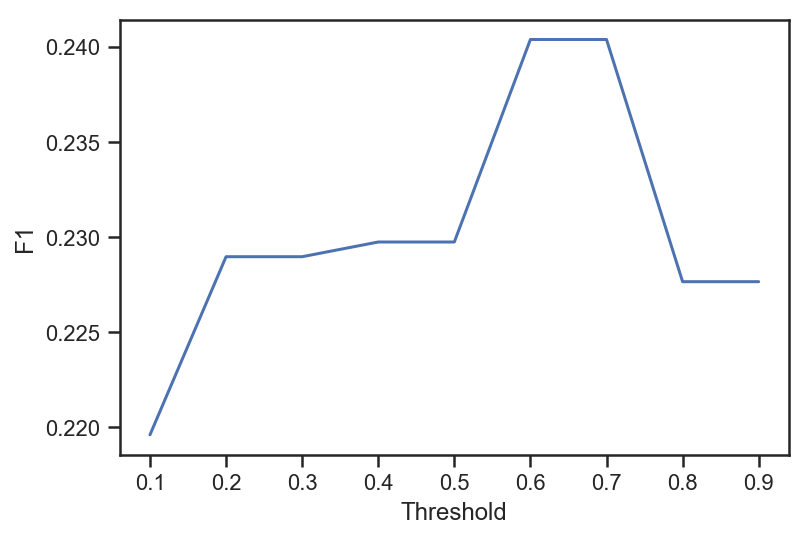

In [42]:
evaluate(predictions6)

---

## Weekly Seasonality + Days Since Previous Release

In [43]:
m7 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
m7.add_regressor("days_since_previous_release")

In [44]:
m7.fit(train_df[["ds", "days_since_previous_release", "y"]])

In [45]:
predictions7 = m7.predict(test_df[["ds", "days_since_previous_release", "y"]])
scaler = MinMaxScaler()
predictions7["yhat"] = scaler.fit_transform(predictions7[["yhat"]])
# predictions7["yhat"].describe()

In [46]:
predictions7 = predictions7.merge(test_df, on=["ds"])

Pearson = 0.30108730602187267
Best F1 = 0.37931034482758624
Precision = 0.28205128205128205
Recall = 0.5789473684210527
Threshold = 0.5


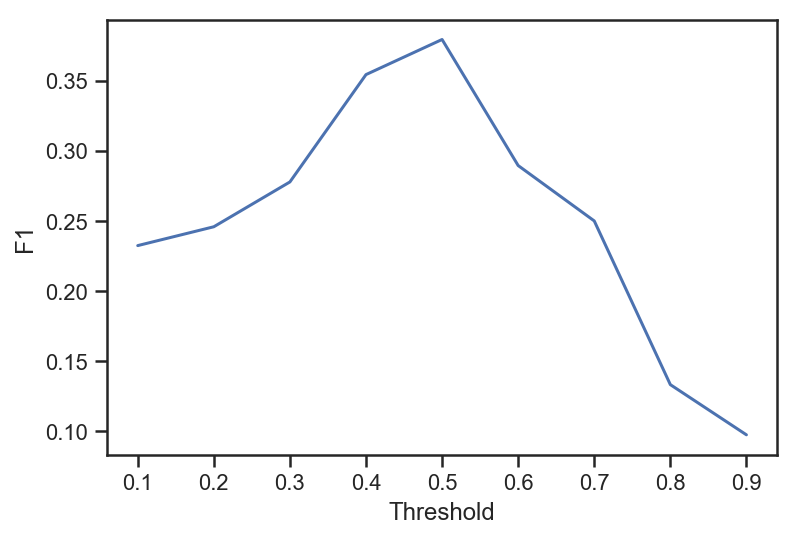

In [47]:
evaluate(predictions7)

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release

In [48]:
m8 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m8.add_regressor("days_since_previous_release")

In [49]:
m8.fit(train_df[["ds", "days_since_previous_release", "y"]])

In [50]:
predictions8 = m8.predict(test_df[["ds", "days_since_previous_release", "y"]])
scaler = MinMaxScaler()
predictions8["yhat"] = scaler.fit_transform(predictions8[["yhat"]])
# predictions8["yhat"].describe()

In [51]:
predictions8 = predictions8.merge(test_df, on=["ds"])

Pearson = 0.31291832263184455
Best F1 = 0.3916083916083916
Precision = 0.26666666666666666
Recall = 0.7368421052631579
Threshold = 0.5


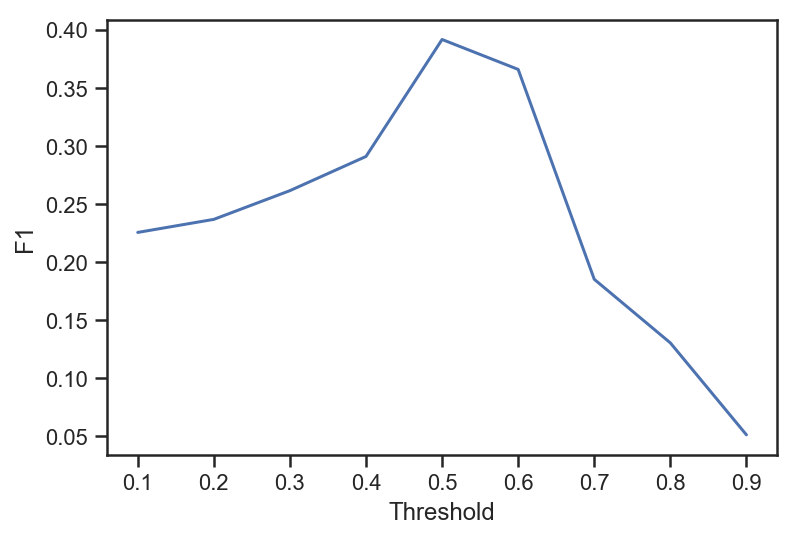

In [52]:
evaluate(predictions8)

In [53]:
# sns.scatterplot(data=predictions8, x="y", y="yhat", hue="y")

In [54]:
# temp = predictions8.copy()
# temp["yhat"] = temp["yhat"].round(2)
# temp = temp.groupby(["y", "yhat"]).size().reset_index()
# sns.lineplot(data=temp, x="yhat", y=0, hue="y")

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday

In [55]:
m9 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m9.add_regressor("days_since_previous_release")
m9.add_regressor("weekday")

In [56]:
m9.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [57]:
predictions9 = m9.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions9["yhat"] = scaler.fit_transform(predictions9[["yhat"]])
# predictions9["yhat"].describe()

In [58]:
predictions9 = predictions9.merge(test_df, on=["ds"])

Pearson = 0.31285561790945726
Best F1 = 0.3888888888888889
Precision = 0.2641509433962264
Recall = 0.7368421052631579
Threshold = 0.5


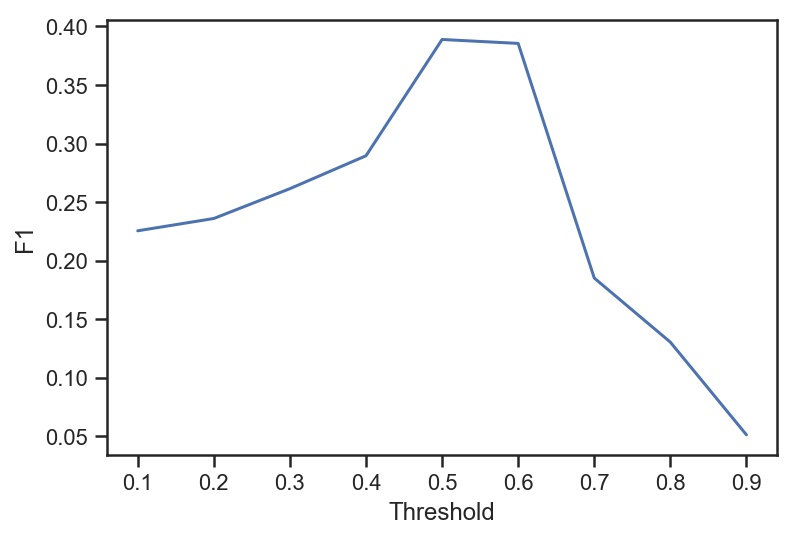

In [59]:
evaluate(predictions9)

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays

In [60]:
m10 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m10.add_regressor("days_since_previous_release")
m10.add_regressor("weekday")
m10.add_country_holidays(country_name="US")

In [61]:
m10.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [62]:
predictions10 = m10.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions10["yhat"] = scaler.fit_transform(predictions10[["yhat"]])
# predictions10["yhat"].describe()

In [63]:
predictions10 = predictions10.merge(test_df, on=["ds"])

Pearson = 0.31400132790273083
Best F1 = 0.3916083916083916
Precision = 0.26666666666666666
Recall = 0.7368421052631579
Threshold = 0.5


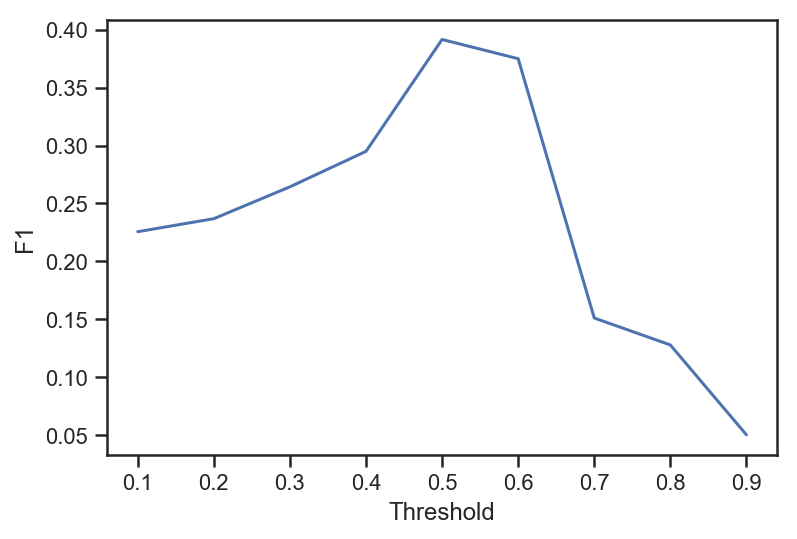

In [64]:
evaluate(predictions10)

In [65]:
# sns.scatterplot(data=predictions10, x="ds", y="yhat", hue="y")

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Multiplicative Seasonality

In [66]:
m11 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
              seasonality_mode="multiplicative")
m11.add_regressor("days_since_previous_release")
m11.add_regressor("weekday")
m11.add_country_holidays(country_name="US")

In [67]:
m11.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [68]:
predictions11 = m11.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions11["yhat"] = scaler.fit_transform(predictions11[["yhat"]])
# predictions11["yhat"].describe()

In [69]:
predictions11 = predictions11.merge(test_df, on=["ds"])

Pearson = 0.3083733292738551
Best F1 = 0.37974683544303794
Precision = 0.36585365853658536
Recall = 0.39473684210526316
Threshold = 0.6


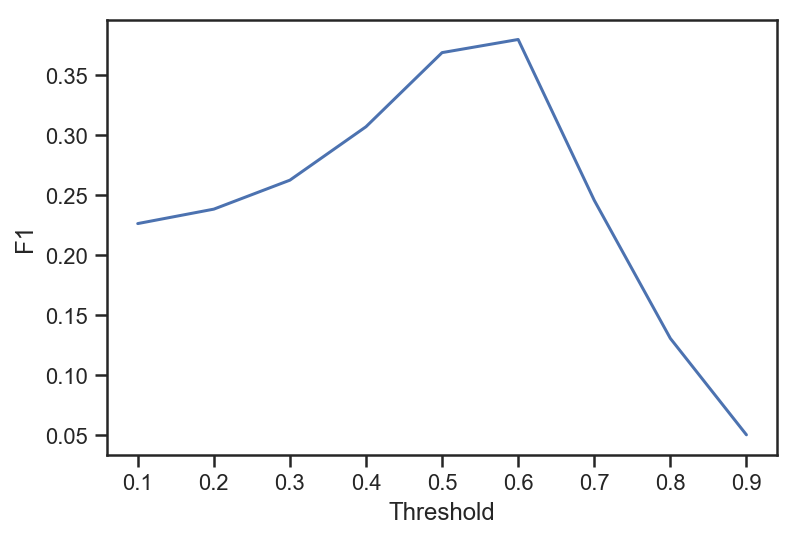

In [70]:
evaluate(predictions11)

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Seasonality Prior Scale Increase

In [71]:
m12 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
              seasonality_prior_scale=100)
m12.add_regressor("days_since_previous_release")
m12.add_regressor("weekday")
m12.add_country_holidays(country_name="US")

In [72]:
m12.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [73]:
predictions12 = m12.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions12["yhat"] = scaler.fit_transform(predictions12[["yhat"]])
# predictions12["yhat"].describe()

In [74]:
predictions12 = predictions12.merge(test_df, on=["ds"])

Pearson = 0.31398759698302114
Best F1 = 0.39436619718309857
Precision = 0.2692307692307692
Recall = 0.7368421052631579
Threshold = 0.5


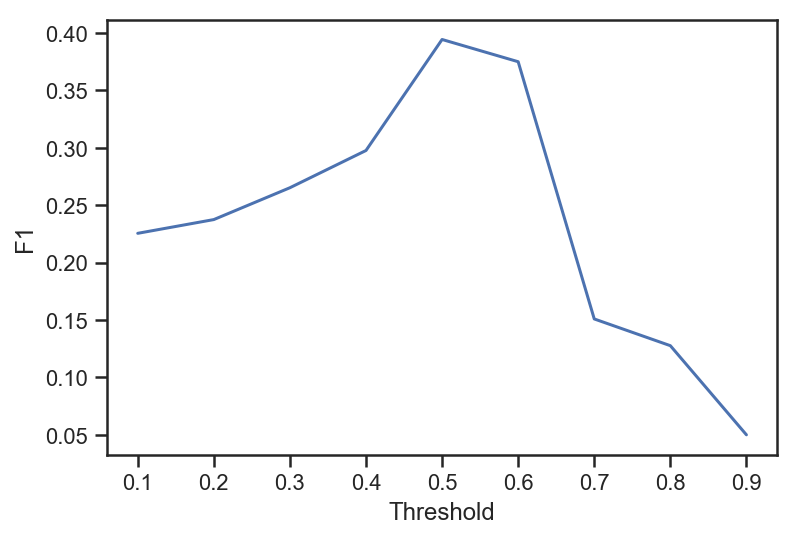

In [75]:
evaluate(predictions12)

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Seasonality Prior Scale Increase + Multiplicative Days Since Previous Release

In [76]:
m13 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
              seasonality_prior_scale=100)
m13.add_regressor("days_since_previous_release", mode="multiplicative")
m13.add_regressor("weekday")
m13.add_country_holidays(country_name="US")

In [77]:
m13.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [78]:
predictions13 = m13.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions13["yhat"] = scaler.fit_transform(predictions13[["yhat"]])
# predictions13["yhat"].describe()

In [79]:
predictions13 = predictions13.merge(test_df, on=["ds"])

Pearson = 0.3126640091573388
Best F1 = 0.39436619718309857
Precision = 0.2692307692307692
Recall = 0.7368421052631579
Threshold = 0.5


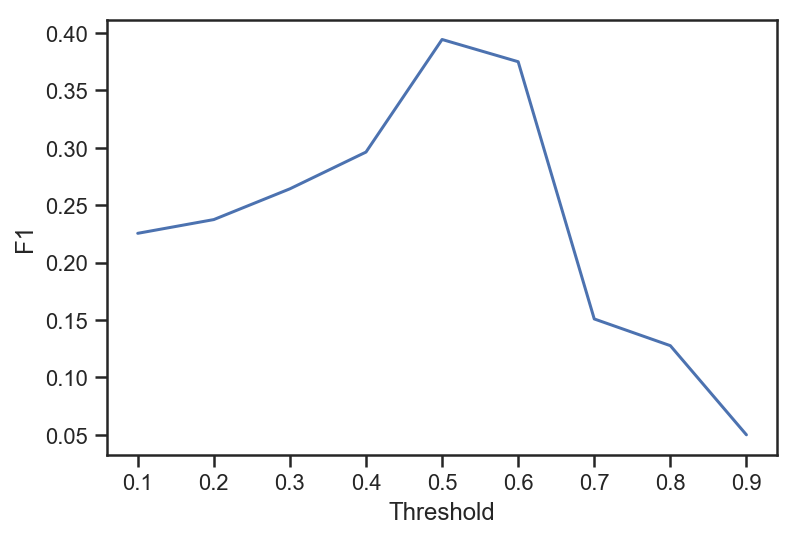

In [80]:
evaluate(predictions13)

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Seasonality Prior Scale Increase + Multiplicative Days Since Previous Release + Fourier Terms on Yearly and Weekly Seasonality

In [81]:
m14 = Prophet(yearly_seasonality=10, weekly_seasonality=10, daily_seasonality=False, 
              seasonality_prior_scale=100)
m14.add_regressor("days_since_previous_release", mode="multiplicative")
m14.add_regressor("weekday")
m14.add_country_holidays(country_name="US")

In [82]:
m14.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [83]:
predictions14 = m14.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions14["yhat"] = scaler.fit_transform(predictions14[["yhat"]])
# predictions14["yhat"].describe()

In [84]:
predictions14 = predictions14.merge(test_df, on=["ds"])

Pearson = 0.31423386103895573
Best F1 = 0.4
Precision = 0.27450980392156865
Recall = 0.7368421052631579
Threshold = 0.5


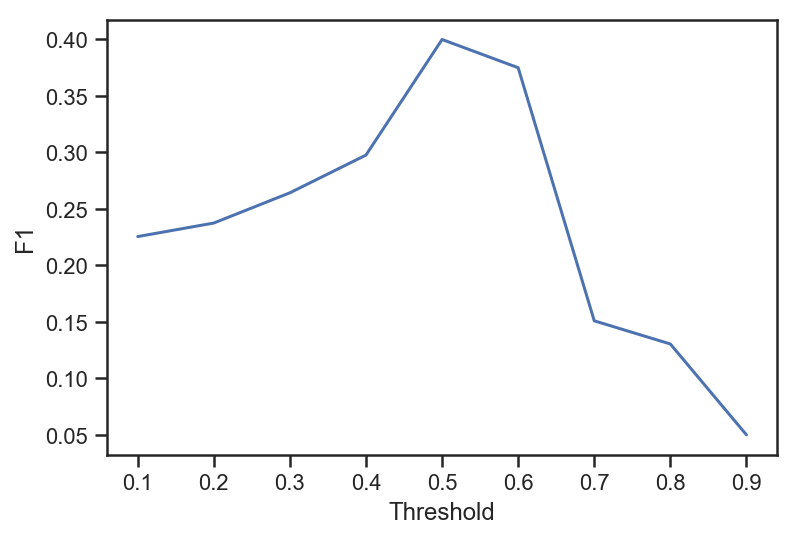

In [85]:
evaluate(predictions14)

In [86]:
# sns.scatterplot(data=predictions14, x="ds", y="yhat", hue="y")